In [1]:
# importing important libraries.
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\DELL\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a depre

In [2]:
# import all english stopwords from nltk.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Importing Dataset
df = pd.read_json('newsgroups.json')
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [175]:
#checking for missing values.
df.isnull().sum()

content         0
target          0
target_names    0
dtype: int64

In [4]:
#checking unique target names.
df.target_names.unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'],
      dtype=object)

### Text Preprocessing

In [5]:
# Remove emails and newline characters
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data[:1]

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ']

In [6]:
# Tokenize words and Clean-up text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [119]:
# Creating unigrams

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [124]:
# Remove Stopwords, Make Bigrams and Lemmatize

In [125]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


In [13]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [14]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'umd', 'organization', 'university', 'park', 'line', 'wonder', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [18]:
# create a dictionary which will be the input for LDA model

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)]]


In [20]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('saw', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

# Model building and evaluting.

In [130]:
select_topics = []
for i in [5, 10, 15, 20, 30, 40]:
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)


    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    select_topics.append({"No of Topics": i, "Coherence Score": coherence_lda})


Perplexity:  -8.480763918164163

Coherence Score:  0.5983203329724492

Perplexity:  -9.372611613797172

Coherence Score:  0.536440419313845

Perplexity:  -12.830773664156295

Coherence Score:  0.5268968535869838

Perplexity:  -14.3718174786959

Coherence Score:  0.4871744774360211

Perplexity:  -18.82988113196323

Coherence Score:  0.450305582885823

Perplexity:  -22.20000582202591

Coherence Score:  0.45057622704905087


In [136]:
select_topics_df = pd.DataFrame(select_topics)

In [138]:
select_topics_df

,No. of Topics,Coherence Score
0,5,0.598320
1,10,0.536440
2,15,0.526897
3,20,0.487174
4,30,0.450306
5,40,0.450576


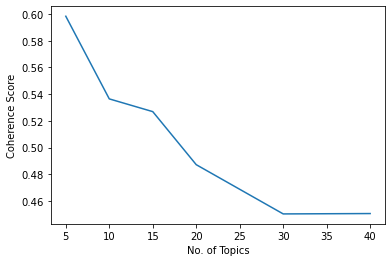

In [143]:
plt.plot(select_topics_df['No. of Topics'], select_topics_df['Coherence Score'])
plt.xlabel('No. of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [144]:
# from above table we can see that best model is with no. of tpoics 5.

In [145]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [146]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"write" + 0.010*"say" + 0.010*"people" + 0.008*"think" + '
  '0.008*"article" + 0.007*"make" + 0.007*"know" + 0.007*"organization" + '
  '0.007*"line" + 0.006*"god"'),
 (1,
  '0.011*"team" + 0.011*"game" + 0.010*"car" + 0.009*"year" + 0.009*"line" + '
  '0.009*"organization" + 0.007*"go" + 0.006*"article" + 0.006*"get" + '
  '0.006*"write"'),
 (2,
  '0.015*"line" + 0.013*"organization" + 0.007*"use" + 0.007*"nntp_poste" + '
  '0.006*"host" + 0.006*"get" + 0.006*"system" + 0.006*"write" + '
  '0.006*"university" + 0.005*"drive"'),
 (3,
  '0.009*"israel" + 0.006*"state" + 0.005*"year" + 0.005*"go" + '
  '0.005*"israeli" + 0.005*"kill" + 0.004*"war" + 0.004*"government" + '
  '0.004*"armenian" + 0.004*"say"'),
 (4,
  '0.335*"ax" + 0.050*"_" + 0.026*"max" + 0.010*"c" + 0.009*"cx" + 0.007*"ei" '
  '+ 0.005*"rlk" + 0.005*"mr" + 0.004*"m" + 0.003*"mu"')]


# Visualize Topics

In [174]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.178298  0.004403       1        1  36.392074
2      0.147053  0.121441       2        1  35.300944
3      0.026400 -0.287526       3        1  11.385146
1      0.043187  0.120518       4        1  11.048457
4     -0.394938  0.041164       5        1   5.873379, topic_info=         Term          Freq         Total Category  logprob  loglift
5412       ax  29803.000000  29803.000000  Default  30.0000  30.0000
1080        _   4755.000000   4755.000000  Default  29.0000  29.0000
2357      max   2378.000000   2378.000000  Default  28.0000  28.0000
154    people   5903.000000   5903.000000  Default  27.0000  27.0000
898      team   1883.000000   1883.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
393        rm    176.681880    266.729912   Topic5  -6.2203   2.4229
10100      ne    143.985015    189.375278   Topic5  -6.4249   2.5607
387         m    342.217537   2587.700557   Topic5  -5.5592   0.8117
4925       ai    141.109623    228.600214   Topic5  -6.4451   2.3523
3108       md    149.084947    309.095850   Topic5  -6.3901   2.1056

[309 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1080       1  0.042691        _
1080       2  0.028811        _
1080       5  0.928270        _
97         2  0.998603  advance
278        1  0.982774    agree
...      ...       ...      ...
45         1  0.264484     year
45         2  0.084336     year
45         3  0.232458     year
45         4  0.418478     year
12317      5  0.994384       zd

[456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

In [50]:
# Finding the dominant topic and its percentage contribution in each document

In [147]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [148]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

In [163]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

In [164]:
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [167]:
df_dominant_topic.Dominant_Topic.value_counts()

2.0    5356
0.0    3752
1.0    1641
3.0     543
4.0      22
Name: Dominant_Topic, dtype: int64

In [170]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9928,"write, say, people, think, article, make, know...","[virgilio_dean, velasco_jr, arrogance, christi..."
1,1.0,0.9963,"team, game, car, year, line, organization, go,...","[nhl, summary_parse, result, game, play, sat, ..."
2,2.0,0.9914,"line, organization, use, nntp_poste, host, get...","[doug_acker, problem, libxmu, sunos, gcc, repl..."
3,3.0,0.9750,"israel, state, year, go, israeli, kill, war, g...","[serdar_argic, armenian, genocide, muslim, peo..."
4,4.0,0.9998,"ax, _, max, c, cx, ei, rlk, mr, m, mu","[cliff, reply, cliff, organization, university..."
